In [1]:
!pip install keras_applications
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import tensorflow as tf
import pandas as pd 
#import tensorflow_addons as tfa
from tensorflow_datasets import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.xception import Xception, preprocess_input 
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras import backend as K

# places 
#from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils

import time
from matplotlib import pyplot as plt, rc
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import shutil
import re
from glob import glob

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from collections import Counter

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from PIL import Image
import csv
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import euclidean_distances
from tensorflow.keras import layers


from sklearn.preprocessing import MinMaxScaler as MMS

import cv2
from PIL import Image
from scipy import stats

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.applications.xception import Xception, preprocess_input

# places365에 필요한 
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
import matplotlib.image as img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!nvidia-smi

Sat Apr  9 07:54:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   48C    P0    38W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   

In [4]:
cd '/home/ubuntu/image_used_crowdSourcing/'

/home/ubuntu/image_used_crowdSourcing


<style>
    span { color: #aba; }
</style>
## <span style="color:#cba"> 이미지 가져오기
---

In [5]:
df=pd.read_csv('/home/ubuntu/pair_df_없는사진_equal제외.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.drop_duplicates(inplace=True)

In [17]:
score_df = pd.DataFrame(data = {'image':list(df['left_image'])+list(df['right_image'])})

In [6]:
image_size= (448, 448)
image_size_channel = (224, 224, 3)
AUTOTUNE = tf.data.AUTOTUNE

def prepro_image(filepath):
    image = tf.io.read_file(filepath) # CPU나 GPU 사용할 때
    # with open(filepath, "rb") as local_file: # <= change here
    #   image = local_file.read()
    image = tf.image.decode_jpeg(image, channels=3) # 파일에서 읽어온 걸 숫자로 바꿔주는 역할
    #image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size) # 이거 때문인지 166 --> 183.99832 이런 식으로 변하넹?
    # normalization은 모델에 들어가있으니까 빼자~
    #image = preprocess_input(image) # 여기에서 scaling 해주거나 안 해주거나 그런 거겠네
    return image

In [7]:
left_path = tf.data.Dataset.from_tensor_slices(list(df['left_image']))
left = left_path.map(prepro_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#left = left.map(lambda x: tf.image.resize(x, image_size))
# left = left.batch(64)
# left_batch = left.cache().prefetch(buffer_size=AUTOTUNE)

right_path = tf.data.Dataset.from_tensor_slices(list(df['right_image']))
right = right_path.map(prepro_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#right = right.map(lambda x: tf.image.resize(x, image_size))
# right = right.batch(64)
# right_batch = right.cache().prefetch(buffer_size=AUTOTUNE)

binary_label = tf.data.Dataset.from_tensor_slices(list(df['label']))
# binary_label = binary_label.batch(64)
# binary_label = binary_label.cache().prefetch(buffer_size=AUTOTUNE)

cat = []
for i in list(df['label']):
  if i==0:
    cat.append(np.array([1,0]))
  else:
    cat.append(np.array([0,1]))

cat_label=tf.data.Dataset.from_tensor_slices(np.array(cat))

pair_images=tf.data.Dataset.zip((left, right))
cat_binary_labels = tf.data.Dataset.zip((cat_label, cat_label, binary_label))
dataset = tf.data.Dataset.zip((pair_images, cat_binary_labels)) # 여기까지는 ()


# validation 나눠놓기
ratio = 0.8
train_val_dataset = dataset.take(round(len(df) * ratio)) # 107255개가 있음(0~107254)
train_dataset = train_val_dataset.take(round(len(df) * ratio * ratio))
val_dataset = train_val_dataset.skip(round(len(df) * ratio * ratio))
test_images = dataset.skip(round(len(df) * ratio))
test_dataset = dataset.skip(round(len(df) * ratio)) # 107255부터~
# test_stack = right.skip(round(len(df) * ratio)).concatenate(left.skip(round(len(df) * ratio)))


# shuffle
batch_size = 32 # 128이 되면 OOM error 발생함 인프런 질문 답변 참고하기(https://www.inflearn.com/questions/175633)
drop_remainder = False

train_dataset = train_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)
val_dataset = val_dataset.shuffle(buffer_size=2000, reshuffle_each_iteration=True)

train_dataset = train_dataset.batch(batch_size, drop_remainder=drop_remainder)
train_dataset = train_dataset.prefetch(batch_size) # tpu로 돌릴 때는 얘를 삭제해야함

val_dataset = val_dataset.batch(batch_size, drop_remainder=drop_remainder)
val_dataset = val_dataset.prefetch(batch_size)

test_images = test_images.batch(batch_size, drop_remainder=drop_remainder)
# test_score = test_stack.batch(batch_size=4, drop_remainder=drop_remainder)
# test_score_dt = tf.data.Dataset.from_tensor_slices(list(score_df['image']))
# test_score_prepro = test_score_dt.map(prepro_image)
# test_score = test_score_prepro.batch(batch_size=2, drop_remainder=drop_remainder)
test_images = test_images.prefetch(32)

# test 나눠놓기

<style>
    span { color: #aba; }
</style>
## <span style="color:#cba"> VGG_Places365
---

In [8]:
def VGG16_Places365(include_top=True, weights='places',
                    input_tensor=None, input_shape=None,
                    pooling=None,
                    classes=365):
    """Instantiates the VGG16-places365 architecture.
    Optionally loads weights pre-trained
    on Places. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization),
                 'places' (pre-training on Places),
                 or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            
            and width and height should be no smaller than 48.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`, or invalid input shape
        
        """
    WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5'
    WEIGHTS_PATH_NO_TOP = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'

    if not (weights in {'places', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `places` '
                         '(pre-training on Places), '
                         'or the path to the weights file to be loaded.')

    if weights == 'places' and include_top and classes != 365:
        raise ValueError('If using `weights` as places with `include_top`'
                         ' as true, `classes` should be 365')


    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten =include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Block 1
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv1')(img_input)

    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool", padding='valid')(x)

    # Block 2
    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv1')(x)

    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv2')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool", padding='valid')(x)

    # Block 3
    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv1')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv2')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool", padding='valid')(x)

    # Block 4
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool", padding='valid')(x)

    # Block 5
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv3')(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool", padding='valid')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dropout(0.5, name='drop_fc1')(x)

        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dropout(0.5, name='drop_fc2')(x)
        
        x = Dense(365, activation='softmax', name="predictions")(x)

    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x, name='vgg16-places365')

    # load weights
    if weights == 'places':
        if include_top:
            weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)

        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')

    elif weights is not None:
        model.load_weights(weights)

    return model


<style>
    span { color: #aba; }
</style>
## <span style="color:#cba"> RSS-CNN architecture
---

In [9]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

def global_extraction(): # using ResNet50 network without FC layer. 여기 고침

    i = Input(shape=(224, 224, 3))
    vgg_model = VGG16_Places365(weights = 'places',
                                    include_top = False,
                                    input_tensor=i)
    
    model = tf.keras.Sequential() # sequential 기반의 모델 하나 만들기

    for layer in vgg_model.layers[:-1]: # 모델에 vgg_layer 추가하기
        model.add(layer)
    
    model.add(GlobalAveragePooling2D())

    for layer in model.layers[:-3]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
  
    return model

def feature_extraction_network(): # using ResNet50 network without FC layer. 여기 고침

    i = Input(shape=(224, 224, 3))
    vgg_model = VGG16_Places365(weights = 'places',
                                    include_top = False,
                                    input_tensor=i)
    
    model = tf.keras.Sequential() # sequential 기반의 모델 하나 만들기

    for layer in vgg_model.layers[:-1]: # 모델에 vgg_layer 추가하기
        model.add(layer)
    
    model.add(GlobalAveragePooling2D())

    for layer in model.layers[:-3]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
  
    return model

def build_model(input_dim, feature_extraction_network, global_extraction):
        
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)])
    
    input_left = Input(shape=input_dim, name='input_left')
    input_right = Input(shape=input_dim, name='input_right')

    # augmentation --> preprocess_input 
    aug_left = data_augmentation(input_left) # output shape (none, 448, 448, 3)
    aug_right = data_augmentation(input_right)

    # image resize - global에 대해서만
    global_left = Lambda(lambda x: tf.image.resize(x, (224, 224)))(aug_left)
    global_right = Lambda(lambda x: tf.image.resize(x, (224, 224)))(aug_right)   

    # imge preprocess (Imagenet에서 얻은 RGB channel별 평균값을 빼주기 때문에 patch와의 순서 상관없음)
    
    pp_glb_left = preprocess_input(global_left)
    pp_glb_right = preprocess_input(global_right)

    # patch 부분
    #feature_extraction_network = feature_extraction_network()

    left_feature1 = feature_extraction_network(preprocess_input(aug_left[:, 0:224, 0:224, :]))
    left_feature2 = feature_extraction_network(preprocess_input(aug_left[:, 0:224, 224:448, :]))
    left_feature3 = feature_extraction_network(preprocess_input(aug_left[:, 224:448, 0:224, :]))
    left_feature4 = feature_extraction_network(preprocess_input(aug_left[:, 224:448, 224:448, :]))

    right_feature1 = feature_extraction_network(preprocess_input(aug_right[:, 0:224, 0:224, :]))
    right_feature2 = feature_extraction_network(preprocess_input(aug_right[:, 0:224, 224:448, :]))
    right_feature3 = feature_extraction_network(preprocess_input(aug_right[:, 224:448, 0:224, :]))
    right_feature4 = feature_extraction_network(preprocess_input(aug_right[:, 224:448, 224:448, :]))

    left_concat = Concatenate(name='left_concat')([left_feature1, left_feature2, left_feature3, left_feature4])
    right_concat = Concatenate(name='right_concat')([right_feature1, right_feature2, right_feature3, right_feature4])

    concat = Concatenate(name='feature_concat')([left_concat, right_concat])
    x1 = Dropout(rate=0.5)(concat)
    x1 = Dense(512, activation='relu')(x1)
    x1 = Dropout(rate=0.5)(x1)
    patches_loss = Dense(2, activation='softmax', name='patches')(x1)


    # global 부분
    #global_extraction = feature_extraction_network()
    left_global = global_extraction(pp_glb_left)
    right_global = global_extraction(pp_glb_right)

    global_concat = Concatenate()([left_global, right_global])
    x2 = Dropout(rate=0.5)(global_concat)
    x2 = Dense(256, activation='relu')(x2)
    x2 = Dropout(rate=0.5)(x2)
    glb_loss = Dense(2, activation='softmax', name='global')(x2)
    
    # score 부분
    left_total_concat = Concatenate()([left_concat, left_global])
    right_total_concat = Concatenate()([right_concat, right_global])
    
    score_model = tf.keras.Sequential([Dropout(rate=0.5), Dense(256, activation='relu'), Dropout(rate=0.5), Dense(1)])
    
    left_score = score_model(left_total_concat)
    right_score = score_model(right_total_concat)

    diff = Subtract()([right_score, left_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid", name='ranking')(diff)

    # Build model.
    model = Model(inputs = [input_left, input_right], outputs = [patches_loss, glb_loss, prob])
    
    return model, score_model

<style>
    span { color: #aba; }
</style>
## <span style="color:#cba"> model training
---

In [8]:
# input_shape = (4, 28, 28, 3)
input_dim = (448, 448, 3)
#preprocess = preprocess()
feature_extraction_network = feature_extraction_network()
global_extraction = global_extraction()
model, score_model = build_model(input_dim, feature_extraction_network, global_extraction)
#model.summary()
#plot_model(model)

In [46]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_right (InputLayer)       [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_34 (Sequential)     (None, 448, 448, 3)  0           ['input_left[0][0]',             
                                                                  'input_right[0][0]']      

In [10]:
make_folder = f'/home/ubuntu/train_0410_patch_aug_global_sep_again0409/'
if not os.path.exists(make_folder):
  os.makedirs(make_folder) 

In [13]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    # with strategy.scope():
    input_dim = (448, 448, 3)
    feature_extraction_network = feature_extraction_network()
    global_extraction = global_extraction()
    model, score_model = build_model(input_dim, feature_extraction_network, global_extraction)

    model.compile(
    optimizer = tf.keras.optimizers.Adam(0.00001), 
    loss = ["categorical_crossentropy", "categorical_crossentropy", 'binary_crossentropy'],
    metrics='accuracy'
    )
    mcp_cb = ModelCheckpoint(filepath=f'{make_folder}/'+'weights.{epoch:02d}-{val_loss:.3f}.hdf5', monitor='val_loss',
                        save_best_only=False, save_weights_only=True, mode='min', period=1, verbose=1)
    #rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=5, patience=2, mode='min', verbose=1)
    # ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
    #model.fit(x=[np.array([left]), np.array([right])], y=[np.array([np.array([0, 1])]), np.array([1])], epochs=1, validation_split=0.0, batch_size=None)
    history = model.fit(train_dataset, 
          epochs=15, 
          validation_data=val_dataset,
          callbacks=[mcp_cb])
          # validation_split은 dataset은 사용하지 못한다

    #model.fit(x=[np.array([left]), np.array([right])], y=[np.array([0, 1]), np.array([1])], epochs=10, validation_split=0.0, batch_size=None)
    #model.fit(x=pair_batch, y=[cat_label, binary_label], epochs=10, validation_split=0.0, batch_size=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
58925056/58909656 [==============================] - 3s 0us/step
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/15
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:lo

In [11]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    # with strategy.scope():
    input_dim = (448, 448, 3)
    feature_extraction_network = feature_extraction_network()
    global_extraction = global_extraction()
    model, score_model = build_model(input_dim, feature_extraction_network, global_extraction)
    
    model.load_weights('/home/ubuntu/weights.09-1.990.hdf5') 

    model.compile(
    optimizer = tf.keras.optimizers.Adam(0.00001), 
    loss = ["categorical_crossentropy", "categorical_crossentropy", 'binary_crossentropy'],
    metrics='accuracy'
    )
    mcp_cb = ModelCheckpoint(filepath=f'{make_folder}/'+'weights.{epoch:02d}-{val_loss:.3f}.hdf5', monitor='val_loss',
                        save_best_only=False, save_weights_only=True, mode='min', period=1, verbose=1)
    #rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=5, patience=2, mode='min', verbose=1)
    # ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
    #model.fit(x=[np.array([left]), np.array([right])], y=[np.array([np.array([0, 1])]), np.array([1])], epochs=1, validation_split=0.0, batch_size=None)
    history = model.fit(train_dataset, 
          epochs=5, 
          validation_data=val_dataset,
          callbacks=[mcp_cb])
          # validation_split은 dataset은 사용하지 못한다

    #model.fit(x=[np.array([left]), np.array([right])], y=[np.array([0, 1]), np.array([1])], epochs=10, validation_split=0.0, batch_size=None)
    #model.fit(x=pair_batch, y=[cat_label, binary_label], epochs=10, validation_split=0.0, batch_size=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/5
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:loc

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
# with strategy.scope():
  input_dim = image_size_channel
  feature_extraction_network = feature_extraction_network()
  model, score_model = build_model(input_dim, feature_extraction_network)
    
  model.load_weights('/home/ubuntu/train_0401_KIN/weights.10-1.314.hdf5') 

  model.compile(
    optimizer = tf.keras.optimizers.Adam(0.00005), 
    loss = ["categorical_crossentropy", 'binary_crossentropy'],
    metrics='accuracy'
    )
  mcp_cb = ModelCheckpoint(filepath=f'{make_folder}/'+'weights.{epoch:02d}-{val_loss:.3f}.hdf5', monitor='val_loss',
                        save_best_only=False, save_weights_only=True, mode='min', period=1, verbose=1)
  #rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=5, patience=2, mode='min', verbose=1)
  # ely_cb = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
  #model.fit(x=[np.array([left]), np.array([right])], y=[np.array([np.array([0, 1])]), np.array([1])], epochs=1, validation_split=0.0, batch_size=None)
  history = model.fit(
          train_dataset, 
          epochs=7, 
          validation_data=val_dataset,
          callbacks=[mcp_cb])
          # validation_split은 dataset은 사용하지 못한다

  #model.fit(x=[np.array([left]), np.array([right])], y=[np.array([0, 1]), np.array([1])], epochs=10, validation_split=0.0, batch_size=None)
  #model.fit(x=pair_batch, y=[cat_label, binary_label], epochs=10, validation_split=0.0, batch_size=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/7
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:loc

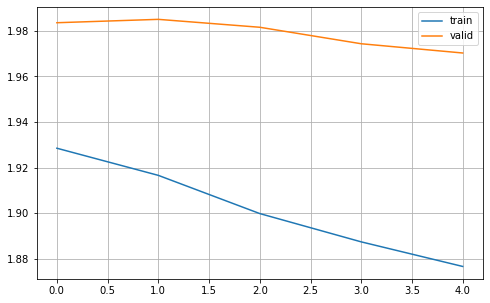

In [21]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
# plt.plot(history.history['feature_loss_loss'], label='train_feature', linestyle='dotted')
# plt.plot(history.history['val_feature_loss_loss'], label='val_feature', linestyle='dotted')
# plt.plot(history.history['ranking_loss_loss'], label='train_ranking', linestyle='dotted')
# plt.plot(history.history['val_ranking_loss_loss'], label='val_ranking', linestyle='dotted')
plt.legend()
plt.grid(True)
#plt.savefig('/home/ubuntu/patch_aug_global_lr0.00001.jpg', dpi=300, bbox_inches='tight')

In [19]:
pd.DataFrame(data=history.history).to_csv('/home/ubuntu/train0401_patch_aug_global_lr0.00001.csv', index=False)

In [14]:
model.load_weights('/home/ubuntu/train_0410_patch_aug_global_sep_again0409/weights.04-1.974.hdf5') 
# 모델isd_66/weights.09-0.340.hdf5 
# 모델isd_68/weights.11-0.154.hdf5 # 이게 max였나???????? 0.0001 --> max 
# 모델isd_69/weights.11-0.116.hdf5 #이게 average였나?????? 0.0001 --> max
# 모델isd_70/weights.12-0.158.hdf5 0.0003 

In [15]:
with tf.device('/device:GPU:0'):
  test = model.predict(test_images)

In [17]:
len(test[2])

24179

In [16]:
bi_acc = tf.keras.metrics.BinaryAccuracy()
bi_acc.update_state(list(df['label'][-24179:]), test[2].flatten()) #
print('Final result: ', bi_acc.result().numpy())

Final result:  0.7490384


In [ ]:
keras.metrics.confusion_matrix(list(df['label'][-26814:]), test[1].flatten())

NameError: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  f = feature_extraction_network.predict(test_images)

ValueError: ignored

In [ ]:
test_score_dt = tf.data.Dataset.from_tensor_slices(list(score_df['image']))
test_score_prepro = test_score_dt.map(prepro_image)
test_score = test_score_prepro.batch(batch_size=2, drop_remainder=True)

In [ ]:
tmp 

,image,score
999,111040189904.jpg,-0.858667
998,111038620903.jpg,1.504694
997,111001578302.jpg,1.078477
996,110671879004.jpg,-0.250278
995,111041243703.jpg,-2.210194
...,...,...
4,110987705503.jpg,-0.785842
3,111019138901.jpg,1.754476
2,111011929003.jpg,-0.987214
1,111015746404.jpg,-1.397151


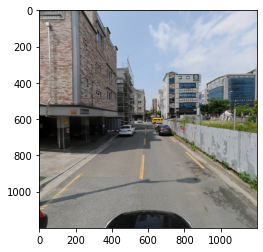

In [ ]:
image = img.imread('111000031803.jpg')
plt.imshow(image)
plt.show()

In [ ]:
plt.hist(score_df)

In [ ]:
test_score_dt = tf.data.Dataset.from_tensor_slices(list(score_df['image']))
test_score_prepro = test_score_dt.map(prepro_image)
test_score = test_score_prepro.batch(batch_size=2, drop_remainder=drop_remainder)

In [ ]:
len(score_df)

30029

In [ ]:
for start_index, end_index in zip(range(0, 10000-490, 490), range(490, 10000+232, 490)):
  print(start_index, end_index)

In [ ]:
test_total_df = pd.DataFrame(columns=['image', 'score'])

with tf.device('/device:GPU:0'):
  for start, end in zip(range(0, len(score_df), 1000), range(1000, len(score_df), 1000)):
    print(start, end)
    test_score_dt = tf.data.Dataset.from_tensor_slices(list(score_df['image'][start:end]))
    test_score_prepro = test_score_dt.map(prepro_image)
    test_score = test_score_prepro.batch(batch_size=2, drop_remainder=drop_remainder)
    score = score_model.predict(feature_extraction_network.predict(test_score))
    test_total_df = test_total_df.append(pd.DataFrame(data={'image':list(score_df['image'][start:end]),
                                          'score':score.flatten()}), ignore_index=True)

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000


In [ ]:
with tf.device('/device:GPU:0'):
    test_score_dt = tf.data.Dataset.from_tensor_slices(list(score_df['image'][-29:]))
    test_score_prepro = test_score_dt.map(prepro_image)
    test_score = test_score_prepro.batch(batch_size=1, drop_remainder=drop_remainder)
    score = score_model.predict(feature_extraction_network.predict(test_score))
    test_total_df = test_total_df.append(pd.DataFrame(data={'image':list(score_df['image'][-29:]),
                                          'score':score.flatten()}), ignore_index=True)

In [ ]:
score.shape

(29, 1)

In [19]:
d = pd.DataFrame(data=history.history)

In [20]:
d.to_csv('/home/ubuntu/sep_loss_from10_to14.csv', index=False)

In [ ]:
with tf.device('/device:GPU:0'):
  score = score_model.predict(feature_extraction_network.predict(test_score))

ResourceExhaustedError: ignored

In [ ]:
score.shape

(1000, 1)

In [ ]:
tmp['score'] = score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tmp.sort_values(by='score')
110988208804.jpg	-3.086008

,image,score
815,110988208804.jpg,-3.086008
145,110973345304.jpg,-2.959976
793,111017077903.jpg,-2.705365
489,111002944801.jpg,-2.407526
230,110988120104.jpg,-2.404147
...,...,...
136,111013558302.jpg,3.169669
61,111031152304.jpg,3.205871
589,110990550402.jpg,3.900252
122,110990550402.jpg,3.900252


In [ ]:
score_df1000 = score_df.iloc[:1000]

In [ ]:
score_df1000['score'] = score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
score.shape

(1000, 1)

In [ ]:
score_df1000.to_csv('/content/drive/MyDrive/lx_siameseModel/scord_df1000.csv', index=False)

In [ ]:
score700 = np.concatenate([score400, score1])

In [ ]:
score1000 = np.concatenate([score700, score2])

In [ ]:
score2.shape

(200, 1)

In [ ]:
make_folder = f'/content/drive/MyDrive/lx_siameseModel/graph'
if not os.path.exists(make_folder):
  os.makedirs(make_folder) 

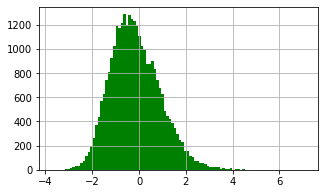

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(test_total_df['score'], bins=100, color='green');
plt.grid(True)
plt.savefig('/content/drive/MyDrive/lx_siameseModel/graph/test_score_30029_hist.jpg', dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.metrics import classfication_report
print(classfication_report(list(df['label'][-26814:]), test[1].flatten()))

ImportError: ignored

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(list(df['label'][-26814:]), y_pred))

NameError: ignored

In [ ]:
y_true=list(map(lambda x:1 if x>0.5 else 0, list(df['label'][-26814:])))

In [ ]:
p = Image.open('/content/drive/Othercomputers/MyNotebook/gbg_w300_h-1/'+class_dirs[i])
ax.imshow(p)

,Unnamed: 0,left_image,right_image,choice,label
0,1,110993404404.jpg,110987798803.jpg,right,1
1,1,111028531201.jpg,111030663404.jpg,right,1
2,2,110999572203.jpg,110992256704.jpg,right,1
3,3,110992365404.jpg,111030727604.jpg,left,0
4,4,111030688804.jpg,111032970202.jpg,right,1
...,...,...,...,...,...
134064,140630,111035028502.jpg,111029634702.jpg,left,0
134065,140631,111013197401.jpg,110984356003.jpg,left,0
134066,140632,111030954003.jpg,110987392204.jpg,right,1
134067,140633,110987909603.jpg,111012168202.jpg,right,1


In [ ]:
score_df940.sort_values(by='score', ascending=False)['image'][20]

'111012968504.jpg'

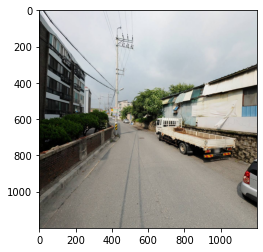

In [ ]:
import matplotlib.image as img

image = img.imread(score_df940.sort_values(by='score', ascending=False)['image'][35])
plt.imshow(image)
plt.show()

In [ ]:
score_df940.sort_values(by='score', ascending=False)

,image,score
461,111040643902.jpg,4.187151
122,110990550402.jpg,3.900252
61,111031152304.jpg,3.205871
136,111013558302.jpg,3.169669
54,110982884702.jpg,3.157456
...,...,...
230,110988120104.jpg,-2.404147
489,111002944801.jpg,-2.407526
793,111017077903.jpg,-2.705365
145,110973345304.jpg,-2.959976


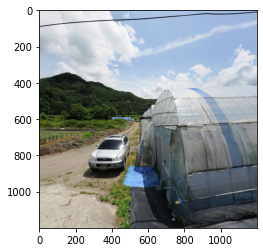

In [ ]:
import matplotlib.image as img

image = img.imread('110982884702.jpg')
plt.imshow(image)
plt.show()

<style>
    span { color: #aba; }
</style>
## <span style="color:#cba"> VGG16 based RSS-CNN + Activation Map(2109016 회의준비)
---

In [ ]:
# input_shape = (4, 28, 28, 3)
input_dim = (128, 128, 3)
feature_extraction_network = feature_extraction_network()
model, score_model = build_model(input_dim, feature_extraction_network)
#model.summary()
#plot_model(model)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
score_model.predict(feature_extraction_network.predict(np.array([left])))

array([[0.8468166]], dtype=float32)

In [ ]:
score_model.predict(feature_extraction_network.predict(np.array([right])))

array([[1.1998664]], dtype=float32)

In [ ]:
score_model.summary()

Model: "score"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


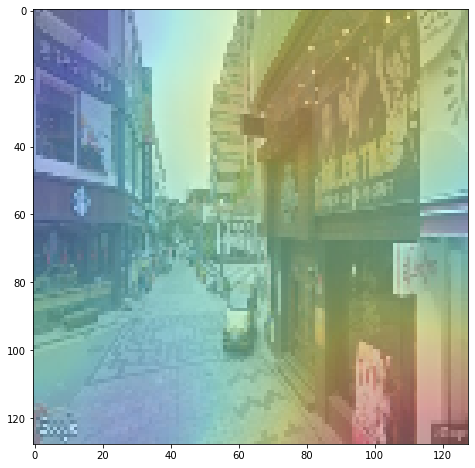

In [ ]:
cam_model1 = tf.keras.Model(inputs = feature_extraction_network.input, outputs=feature_extraction_network.layers[-1].output)
cam_model2 = tf.keras.Model(inputs = score_model.input, outputs=(score_model.layers[-1].output))
#cam_model.summary()

gap_weights = score_model.layers[-1].get_weights()[0]
gap_weights.shape

def show_cam(image_value, features, results):
    '''
    Displays the class activation map of an image
    Args:
    image_value (tensor) -- preprocessed input image with size 224 x 224
    features (array) -- features of the image, shape (1, 7, 7, 512)
    results (array) -- output of the sigmoid layer
    '''
    features_for_img = features[0]
    prediction = results[0]

    class_activation_weigths = gap_weights[:, 0]
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/8, 224/8, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (224,224))
    # visualize the results
    #print(f'sigmoid output: {results}')
    #print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

features = cam_model1.predict(np.array([left]))
results = cam_model2.predict(features)
show_cam(left, features, results)

In [ ]:
feature_extraction_network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)      